## Machine Learning Final Project: Football Player Position Prediction

https://www.kaggle.com/competitions/position-prediction-for-football-players/leaderboard

### Import of libraries used in the project

In [94]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import math
warnings.filterwarnings("ignore")
import datetime


from sklearn import neighbors
from math import sqrt
import itertools

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

### Load of the two datasets from kaggle

In [95]:
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

In [96]:
# concat train data with test data to have more observations to graph it together. 
all_data = pd.concat([df_train,df_test])

<h2>Exploratory Data Analysis

Dimentions of our data, we have almost 7k players and 70 variables for each one on our training dataset

In [97]:
df_test.shape, df_train.shape

((767, 69), (6895, 70))

<h4> First glance at the dataset

In [98]:
df_train.head()

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,65,66,65,14,11,12,12,12,NaN,LB
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,65,61,58,10,13,7,6,11,NaN,LDM
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,60,58,59,10,10,8,10,11,NaN,LWB
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,16,22,19,16,15,13,8,9,NaN,LS
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,64,61,58,12,5,11,12,15,NaN,LB


We define column subsets, some to drop, others by position, etc. This subsets will be used throught the whole model.

In [99]:
columns_rearranged_long = ['id', 'position', 'overall', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'def_rate','att_rate', 'body_type', 'height_cm', 'weight_kg', 'player_traits', 'player_tags', 'skill_moves', 'preferred_foot', 'weak_foot', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'club_jersey_number', 'potential', 'value_eur', 'wage_eur','age', 'club_name', 'league_name', 'league_level', 'club_joined', 'club_contract_valid_until', 'nationality_name', 'international_reputation']
columns_rearranged = ['id', 'position', 'overall', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'def_rate','att_rate', 'body_type', 'height_cm', 'weight_kg', 'player_traits', 'player_tags', 'skill_moves', 'preferred_foot', 'weak_foot', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'club_jersey_number', 'potential', 'value_eur', 'wage_eur', 'age', 'club_name', 'league_name', 'league_level', 'club_joined', 'club_contract_valid_until', 'nationality_name', 'international_reputation']
columns_keepers = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']
columns_to_drop = ['club_loaned_from','nation_jersey_number','real_face','short_name','release_clause_eur']
columns_player_attributes_short = ['passing','overall','physic','pace','defending','shooting','dribbling']
columns_player_attributes = ['attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']
player_traits_simplified = ["Crosser", "Speed", "Dribbler", "Finesse", "Shot", "Solid", "Player", "Cautious", "Leadership", "Passes", "Taker", "Throw-in", "Injury", "Playmaker", "Outside", "Technical", "Team", "Tackles", "Power", "Header", "Flair", "Chip", "Free-Kick"]
def_positions = ['LB','LWB','LCB','RB','RCB','RWB','CB']
mid_positions = ['LDM','CDM','RDM','LM','LCM','CM','RCM','RM','CAM']
att_positions = ['LW','RW','LF','ST','LS','RS','RF']

# Columns selected after feature selection
cols_selected_features_lr = ['overall', 'potential', 'age', 'height_cm', 'weight_kg','preferred_foot', 'skill_moves', 'pace', 'shooting', 'passing','defending', 'attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_reactions','movement_balance', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking_awareness','defending_standing_tackle', 'defending_sliding_tackle',
       'playmaker_trait', 'att_rate']+['id','position']
cols_selected_features_rf = ['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm','weight_kg', 'league_level', 'club_jersey_number', 'club_joined','club_contract_valid_until', 'preferred_foot', 'weak_foot','skill_moves', 'body_type', 'pace', 'shooting', 'passing', 'dribbling','defending', 'physic', 'attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
        'mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking_awareness','defending_standing_tackle', 'defending_sliding_tackle',
       'dribbler_trait', 'shot_trait', 'att_rate', 'def_rate']+['id','position']
cols_selected_features_lgbm = ['overall', 'potential', 'value_eur', 'wage_eur', 'age', 'height_cm','weight_kg', 'league_level', 'club_jersey_number', 'club_joined','club_contract_valid_until', 'preferred_foot', 'weak_foot', 'body_type','pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic','attacking_crossing', 'attacking_finishing',
        'attacking_heading_accuracy', 'attacking_short_passing','attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control','movement_acceleration', 'movement_sprint_speed', 'movement_agility','movement_reactions', 'movement_balance', 'power_shot_power','power_jumping', 'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure', 'defending_marking_awareness','defending_standing_tackle', 'defending_sliding_tackle',
       'dribbler_trait', 'playmaker_trait', 'shot_trait', 'att_rate']+['id','position']

<h4> We plot the ln(wages) of the players by position. We see that the distribution for defender's wages seems to be the one with the lower relative wages and strikers higher ones. The three of them are negatively skewed which makes sense.

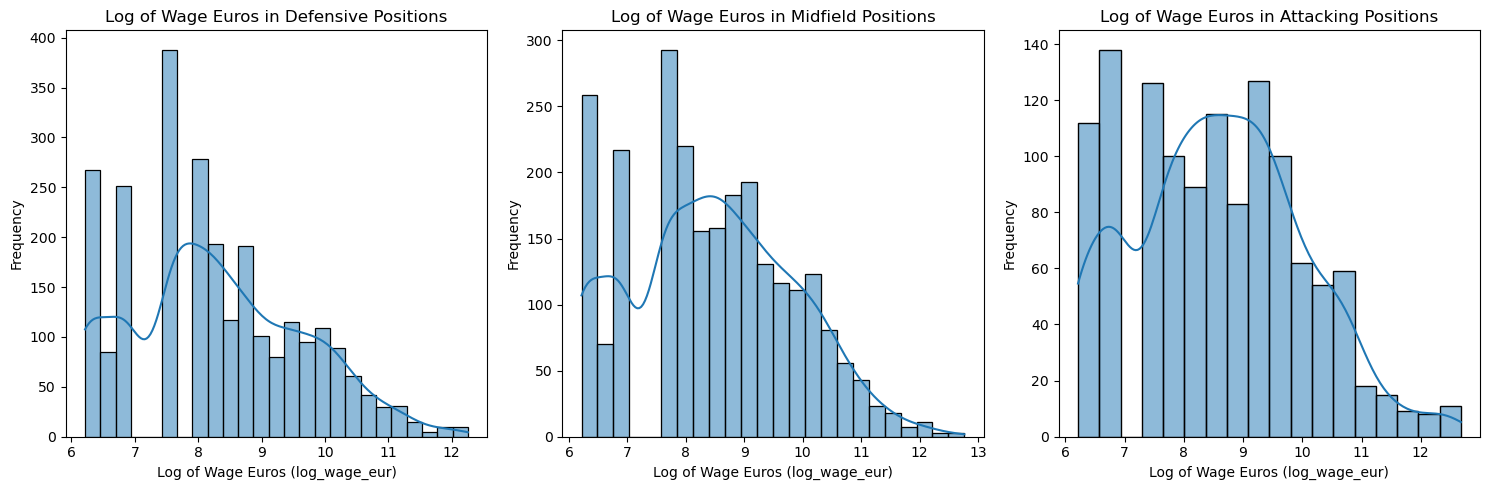

In [100]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Function to plot histogram for a specific position category
def plot_histogram_for_positions(position_list, title, ax):
    # Filter data for specific positions
    filtered_data = all_data[all_data['position'].isin(position_list)]

    # Apply log transformation to wage for the filtered data
    filtered_data['log_wage'] = filtered_data['wage_eur'].apply(lambda x: math.log(x))

    # Plot the histogram using Seaborn for the filtered positions
    sns.histplot(data=filtered_data, x='log_wage', kde=True, ax=ax)
    ax.set_title(f'{title}')
    ax.set_xlabel('Log of Wage Euros (log_wage_eur)')
    ax.set_ylabel('Frequency')

# Plot histograms for different position categories in subplots
plot_histogram_for_positions(def_positions, 'Log of Wage Euros in Defensive Positions', axes[0])
plot_histogram_for_positions(mid_positions, 'Log of Wage Euros in Midfield Positions', axes[1])
plot_histogram_for_positions(att_positions, 'Log of Wage Euros in Attacking Positions', axes[2])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

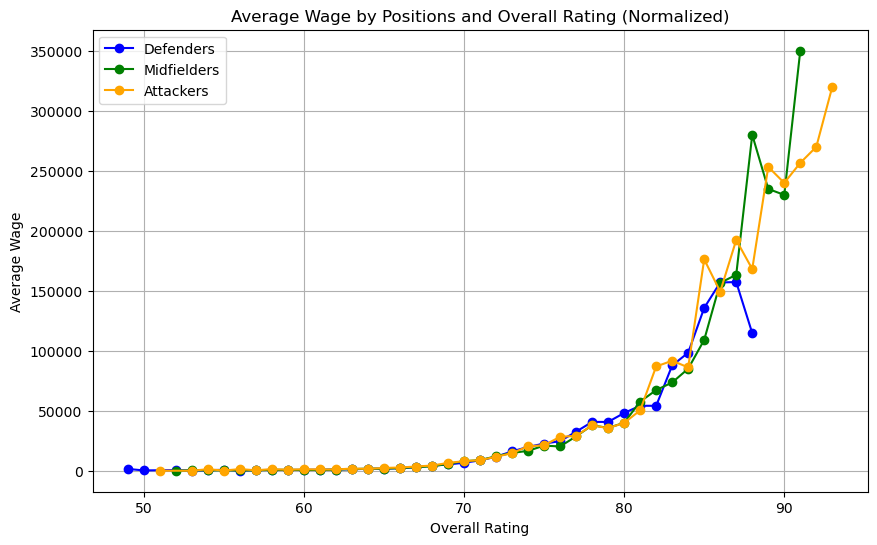

In [101]:

defenders = df_train[df_train['position'].isin(def_positions)]
midfielders = df_train[df_train['position'].isin(mid_positions)]
attackers = df_train[df_train['position'].isin(att_positions)]
avg_def_values = defenders.groupby('overall')['wage_eur'].mean()
avg_mid_values = midfielders.groupby('overall')['wage_eur'].mean()
avg_att_values = attackers.groupby('overall')['wage_eur'].mean()
plt.figure(figsize=(10, 6))
plt.plot(avg_def_values.index, avg_def_values.values, label='Defenders', marker='o', color='blue')
plt.plot(avg_mid_values.index, avg_mid_values.values, label='Midfielders', marker='o', color='green')
plt.plot(avg_att_values.index, avg_att_values.values, label='Attackers', marker='o', color='orange')
plt.title('Average Wage by Positions and Overall Rating (Normalized)')
plt.xlabel('Overall Rating')
plt.ylabel('Average Wage')
plt.legend()
plt.grid(True)
plt.show()

There are no defenders with really high overall ratings, nevertheless one can observe that the wages of the midfielders then to be the highest growing one.

<h4> How does size compare between positions: Weight and Height

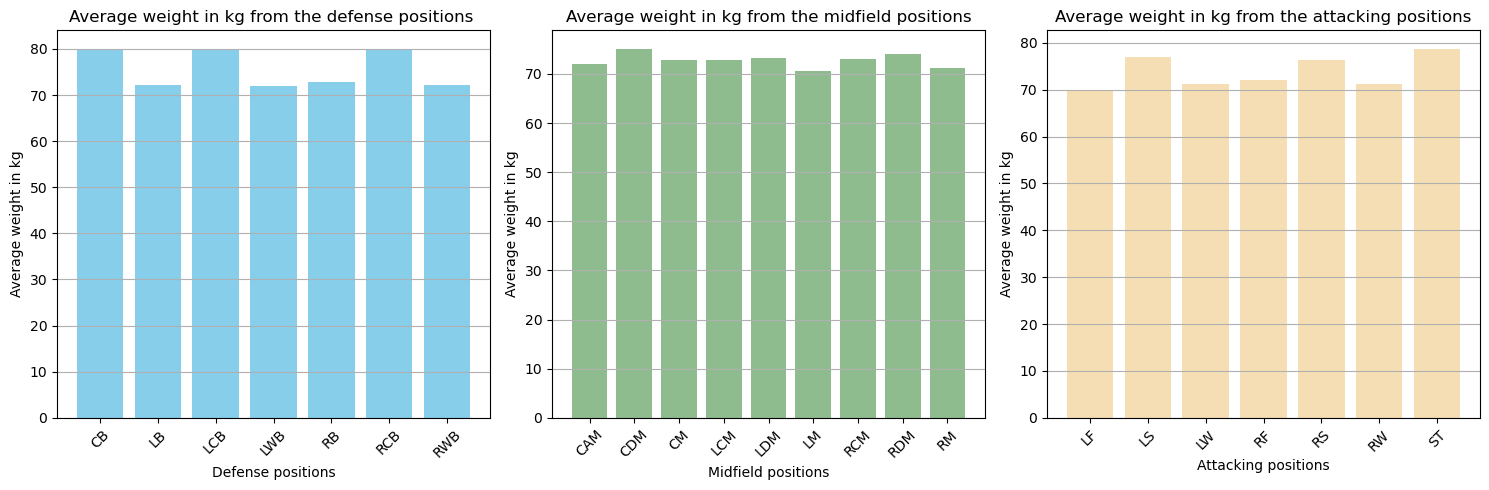

In [102]:
# Calculate the average weight for each position
avg_weight = all_data.groupby('position')['weight_kg'].mean().reset_index()

# Filter average ages for each subplot
filtered_avg_weight_1 = avg_weight[avg_weight['position'].isin(def_positions)]
filtered_avg_weight_2 = avg_weight[avg_weight['position'].isin(mid_positions)]
filtered_avg_weight_3 = avg_weight[avg_weight['position'].isin(att_positions)]

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Subplot 1
axes[0].bar(filtered_avg_weight_1['position'], filtered_avg_weight_1['weight_kg'],color='skyblue')
axes[0].set_title('Average weight in kg from the defense positions ')
axes[0].set_xlabel('Defense positions')
axes[0].set_ylabel('Average weight in kg')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Subplot 2
axes[1].bar(filtered_avg_weight_2['position'], filtered_avg_weight_2['weight_kg'],color='darkseagreen')
axes[1].set_title('Average weight in kg from the midfield positions')
axes[1].set_xlabel('Midfield positions')
axes[1].set_ylabel('Average weight in kg')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Subplot 3
axes[2].bar(filtered_avg_weight_3['position'], filtered_avg_weight_3['weight_kg'],color='wheat')
axes[2].set_title('Average weight in kg from the attacking positions')
axes[2].set_xlabel('Attacking positions')
axes[2].set_ylabel('Average weight in kg')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

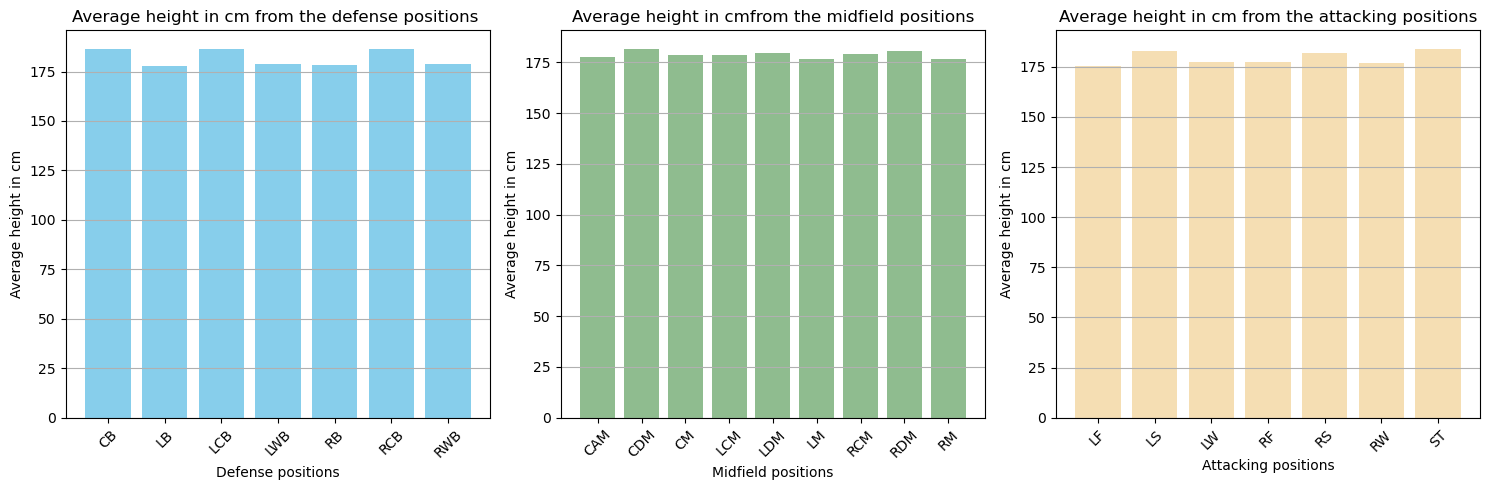

In [103]:
# Calculate the average height for each position
avg_height = all_data.groupby('position')['height_cm'].mean().reset_index()


# Filter average ages for each subplot
filtered_avg_height_1 = avg_height [avg_height ['position'].isin(def_positions)]
filtered_avg_height_2 = avg_height [avg_height ['position'].isin(mid_positions)]
filtered_avg_height_3 = avg_height [avg_height ['position'].isin(att_positions)]

# Create a figure with 3 subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Subplot 1
axes[0].bar(filtered_avg_height_1['position'], filtered_avg_height_1['height_cm'],color='skyblue')
axes[0].set_title('Average height in cm from the defense positions ')
axes[0].set_xlabel('Defense positions')
axes[0].set_ylabel('Average height in cm')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y')

# Subplot 2
axes[1].bar(filtered_avg_height_2['position'], filtered_avg_height_2['height_cm'],color='darkseagreen')
axes[1].set_title('Average height in cmfrom the midfield positions')
axes[1].set_xlabel('Midfield positions')
axes[1].set_ylabel('Average height in cm')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y')

# Subplot 3
axes[2].bar(filtered_avg_height_3['position'], filtered_avg_height_3['height_cm'],color='wheat')
axes[2].set_title('Average height in cm from the attacking positions')
axes[2].set_xlabel('Attacking positions')
axes[2].set_ylabel('Average height in cm')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(axis='y')

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()

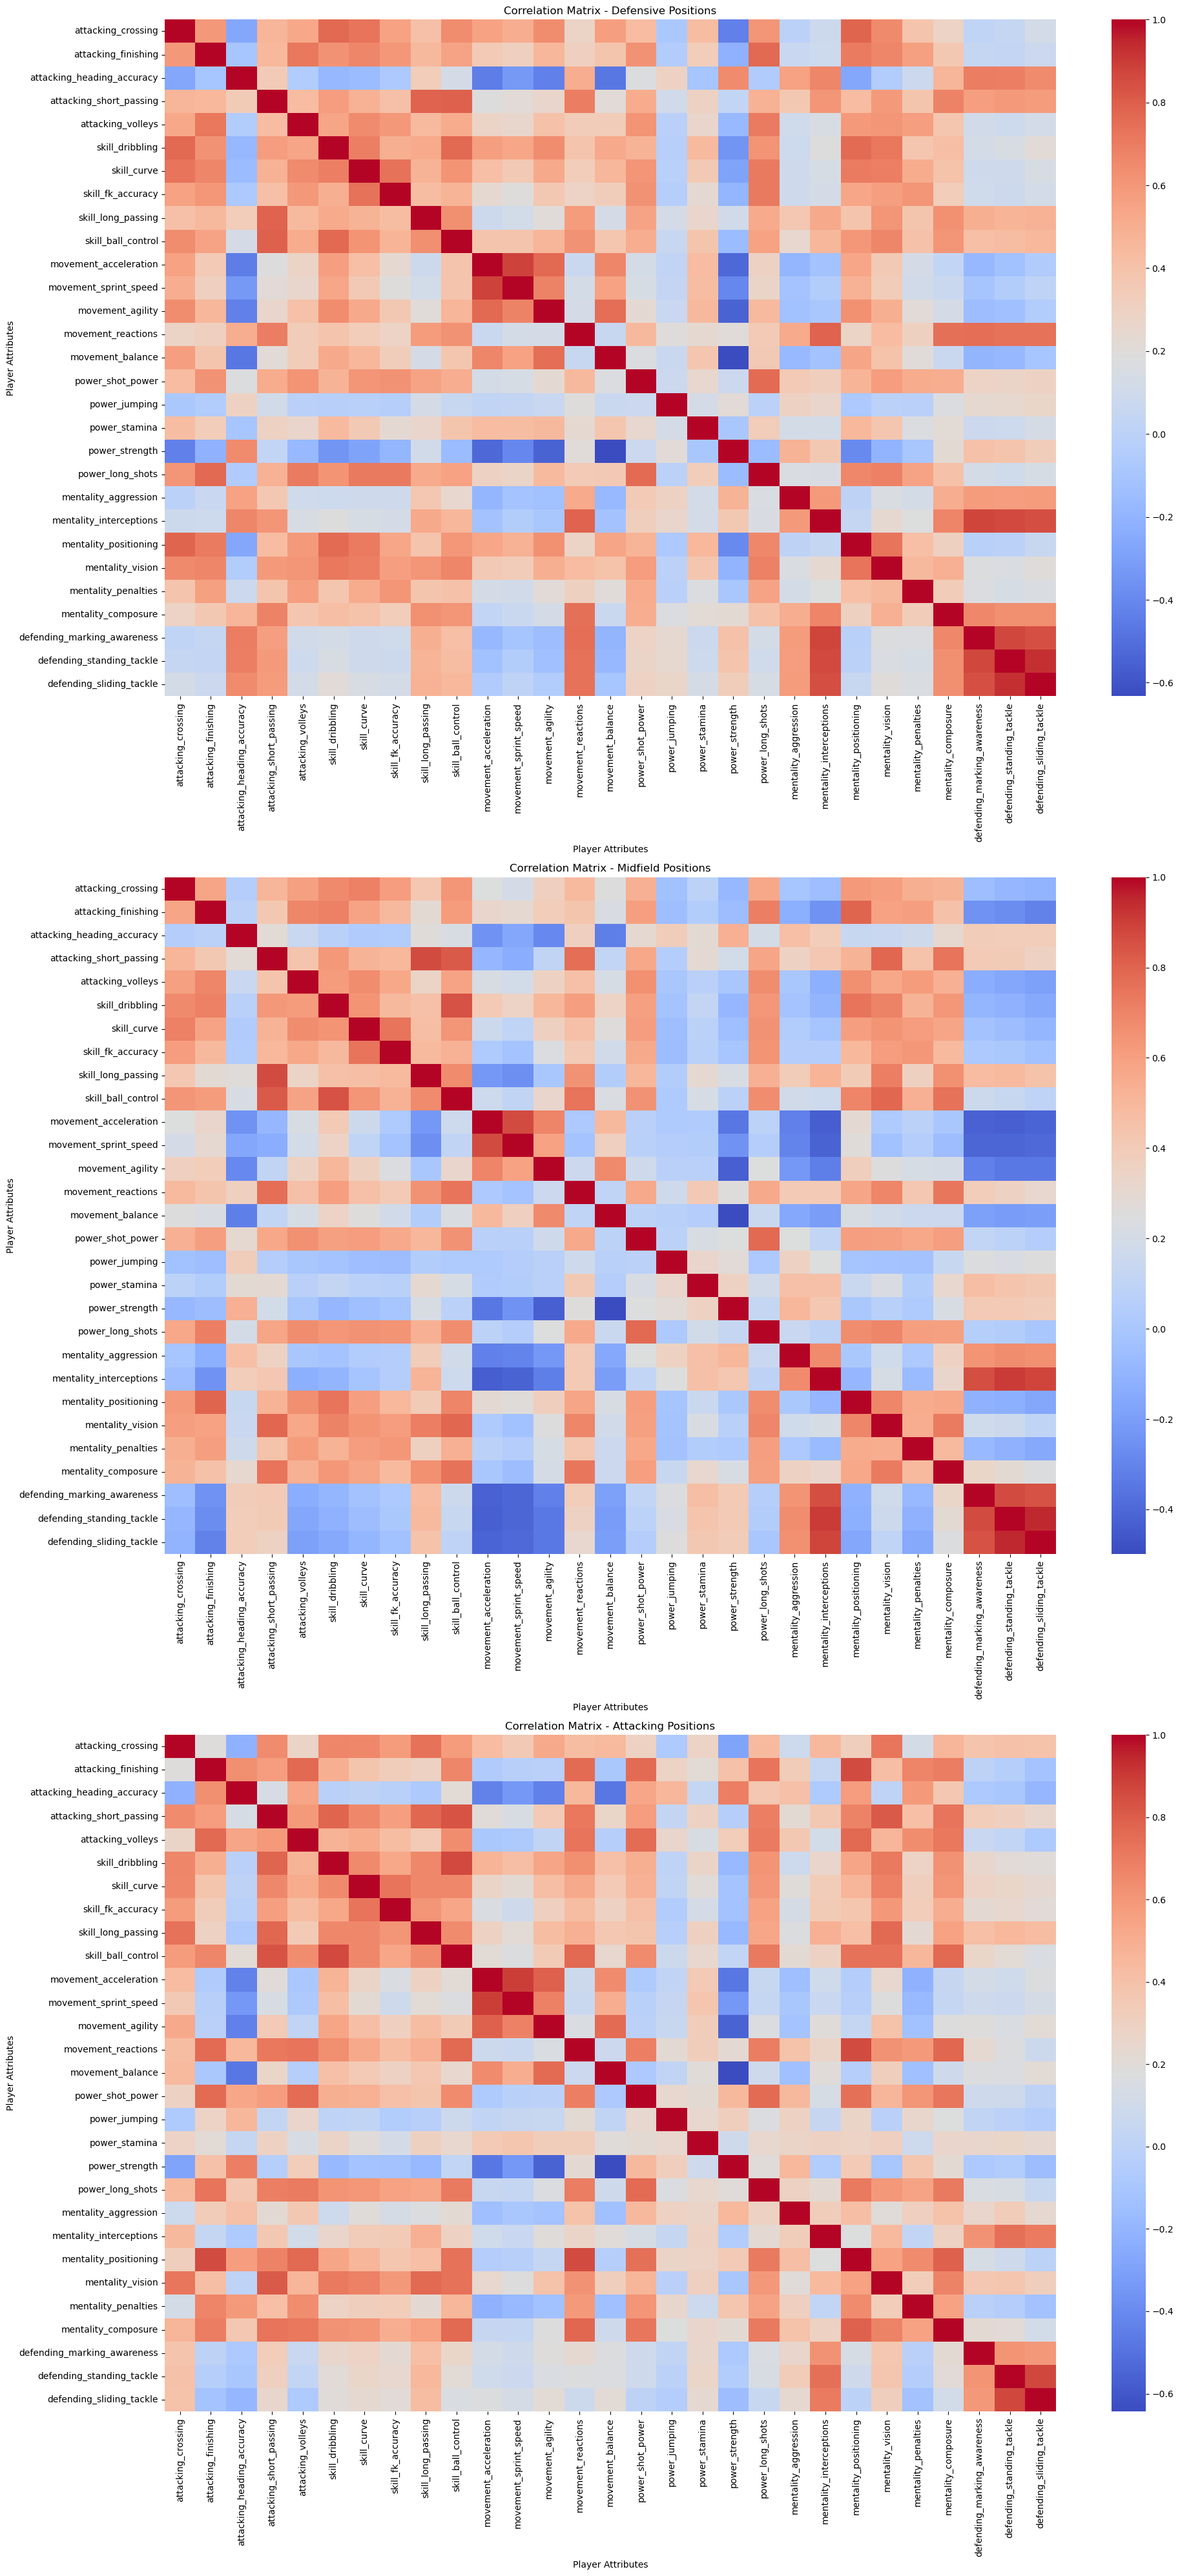

In [104]:

# Function to plot correlation matrix for a specific position category
def plot_corr_matrix_for_positions(position_list, title, ax):
    # Filter data for specific positions
    filtered_data = df_train[df_train['position'].isin(position_list)]

    # Calculate correlation matrix for the filtered positions
    corr_matrix = filtered_data[columns_player_attributes].corr()

    # Plot the correlation matrix heatmap
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax)
    ax.set_title(f'{title}')
    ax.set_xlabel('Player Attributes')
    ax.set_ylabel('Player Attributes')

# Create subplots
fig, axes = plt.subplots(nrows=3, figsize=(20,40 ))



# Plot correlation matrices for different position categories in subplots
plot_corr_matrix_for_positions(def_positions, 'Correlation Matrix - Defensive Positions', axes[0])
plot_corr_matrix_for_positions(mid_positions, 'Correlation Matrix - Midfield Positions', axes[1])
plot_corr_matrix_for_positions(att_positions, 'Correlation Matrix - Attacking Positions', axes[2])

# Adjust layout and display the subplots
plt.tight_layout()
plt.show()


For defensive positions, we clearly see that defensive attributes such as standing tackle, or marking awareness is much more correlated with other defensive attributes than in attacking positions. This same trend seems to appear for attacking attributes in strikers and wingers. Midfilders show negative correlations in some key variables, like accelerations and mental attributes; this could be due to the fact that midfilders ususally are more rounded players and do not excel in any specific area or characteristic.

<h4> Now, we want to see how the Player's overall rating, representing their overall skill level; and Player's skill moves rating, representing their dribbling and ball control skills with respect with the position.

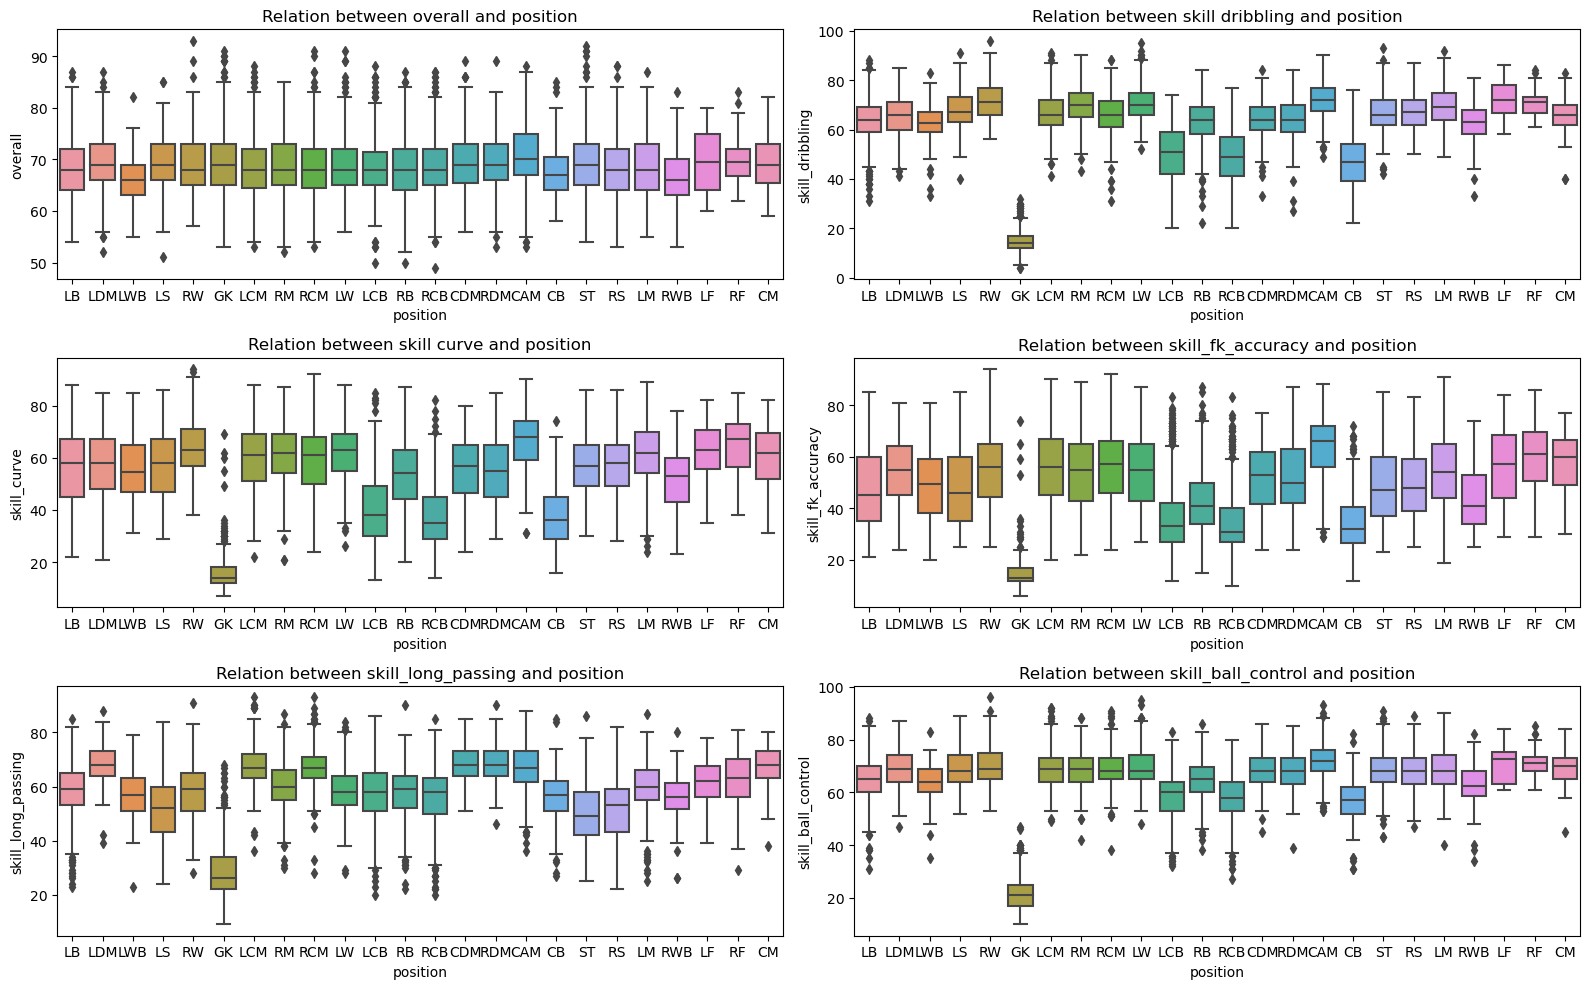

In [105]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 10))

# 1 subplot
sns.boxplot(x='position', y='overall', data=df_train, ax=axs[0, 0])
axs[0, 0].set_title('Relation between overall and position')

# 2 subplot
sns.boxplot(x='position', y='skill_dribbling', data=df_train, ax=axs[0, 1])
axs[0, 1].set_title('Relation between skill dribbling and position')

# 3 subplot
sns.boxplot(x='position', y='skill_curve', data=df_train, ax=axs[1, 0])
axs[1, 0].set_title('Relation between skill curve and position')

# 4 subplot
sns.boxplot(x='position', y='skill_fk_accuracy', data=df_train, ax=axs[1, 1])
axs[1, 1].set_title('Relation between skill_fk_accuracy and position')

# 5 subplot
sns.boxplot(x='position', y='skill_long_passing', data=df_train, ax=axs[2, 0])
axs[2, 0].set_title('Relation between skill_long_passing and position')

# 6 subplot
sns.boxplot(x='position', y='skill_ball_control', data=df_train, ax=axs[2, 1])
axs[2, 1].set_title('Relation between skill_ball_control and position')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

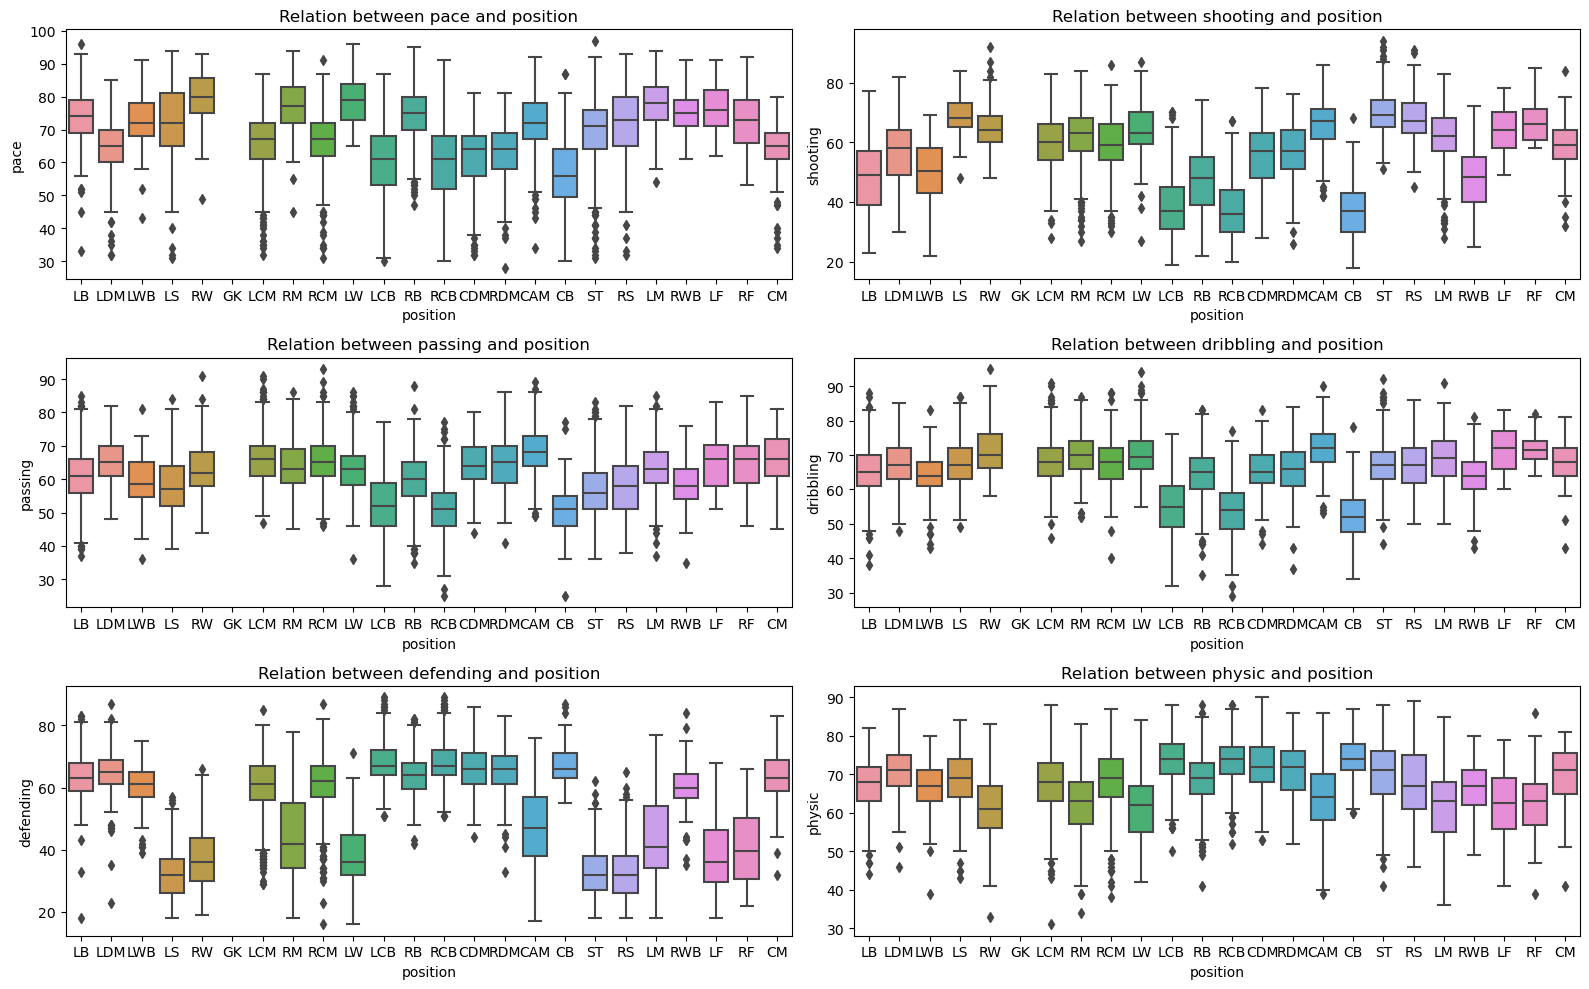

In [106]:
# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(16, 10))

# 1 subplot
sns.boxplot(x='position', y='pace', data=df_train, ax=axs[0, 0])
axs[0, 0].set_title('Relation between pace and position')

# 2 subplot
sns.boxplot(x='position', y='shooting', data=df_train, ax=axs[0, 1])
axs[0, 1].set_title('Relation between shooting and position')

# 3 subplot
sns.boxplot(x='position', y='passing', data=df_train, ax=axs[1, 0])
axs[1, 0].set_title('Relation between passing and position')

# 4 subplot
sns.boxplot(x='position', y='dribbling', data=df_train, ax=axs[1, 1])
axs[1, 1].set_title('Relation between dribbling and position')

# 5 subplot
sns.boxplot(x='position', y='defending', data=df_train, ax=axs[2, 0])
axs[2, 0].set_title('Relation between defending and position')

# 6 subplot
sns.boxplot(x='position', y='physic', data=df_train, ax=axs[2, 1])
axs[2, 1].set_title('Relation between physic and position')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the subplots
plt.show()

<h3> Clearly, Goalkeepers need to be treated differently, we know they will have different type of stats.

<h4> All important variables seem to be full with data. We understand that 9.15% of NAs in some variables is due to the fact that goalkeepers do not have this type of statistic

In [107]:
# check sum of missing percentages to see what we are working with 

missing_percentages = all_data.isnull().sum() / len(all_data) * 100

# Filter columns where missing percentage is different from zero
missing_nonzero = missing_percentages[missing_percentages != 0]

# Print missing percentages for columns with non-zero missing values
for column, percentage in missing_nonzero.items():
     print(f"Column '{column}': {percentage:.2f}% missing")


Column 'value_eur': 0.07% missing
Column 'club_loaned_from': 94.83% missing
Column 'club_joined': 5.17% missing
Column 'nation_jersey_number': 93.94% missing
Column 'release_clause_eur': 5.23% missing
Column 'player_tags': 88.83% missing
Column 'player_traits': 37.51% missing
Column 'pace': 9.15% missing
Column 'shooting': 9.15% missing
Column 'passing': 9.15% missing
Column 'dribbling': 9.15% missing
Column 'defending': 9.15% missing
Column 'physic': 9.15% missing
Column 'goalkeeping_speed': 90.85% missing
Column 'position': 10.01% missing


<h3>The frecuency of our target variable

RCB    631
GK     631
LCB    631
RB     463
LB     463
ST     428
RCM    423
LCM    423
RM     369
LM     369
CAM    263
RDM    201
LS     201
RS     201
LDM    201
CB     167
RW     166
LW     166
CDM    151
LWB    104
RWB    104
CM      75
LF      32
RF      32
Name: position, dtype: int64


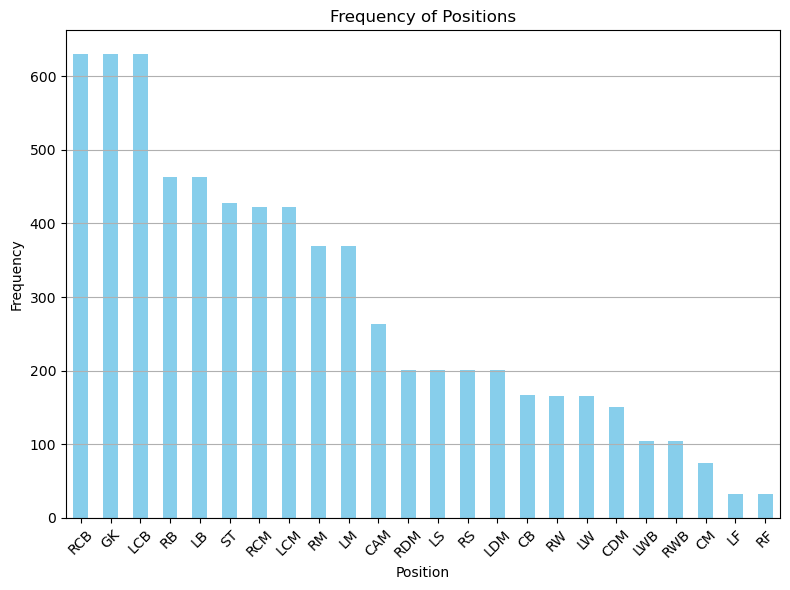

In [108]:
value_counts = all_data['position'].value_counts()
print(value_counts)
plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Frequency of Positions')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Functions implemented throughout the model

In [109]:
def remove_goalkeepers(df):
    df_goalkeepers = df[df['goalkeeping_speed'].notna()].copy()
    df.drop(df_goalkeepers.index, inplace=True)
    return df,df_goalkeepers

def handle_club_joined(df):
    # change club_joined 2021-07-24 from int of the year except nan
    df['club_joined'] = df['club_joined'].apply(lambda x: pd.to_datetime(x).year if type(x) == str else 2021)
    return df

#If we have an NA, we input the minimun transfer value.
def handle_value_eur(df):
    df['value_eur'] = df['value_eur'].apply(lambda x: 20000 if np.isnan(x) else x)
    return df

#Turning variable from categorical to numerical
def handle_foot(df):
    df['preferred_foot'] = df['preferred_foot'].apply(lambda x: 1 if x == 'Right' else 0)
    return df

# Player_tags column can contain multiple strings, this is function uses TfidfVectorizer (with a limit of max_features) to create a new column for each tag
def handle_player_tags(df, max_features=None):
    df['player_tags'].fillna('', inplace=True)
    df['player_tags'] = df['player_tags'].apply(lambda x: x.split(','))
    df['combined_tags'] = df['player_tags'].apply(lambda x: ', '.join(x))
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_tags'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()+'_tag')
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis=1)
    df.drop(['player_tags', 'combined_tags'], axis=1, inplace=True)
    return df

# Player_traits column can contain multiple strings, only the key traits are kept (see player_traits_simplified)
# Then this is function uses TfidfVectorizer (with a limit of max_features) to create a new column for each trait
def handle_player_traits(df,max_features=None):
    def transform_player_trait(trait):
        if pd.notna(trait):  # Check for NaN values
            relevant_words = [word for word in trait.split() if word in player_traits_simplified]
            return ', '.join(relevant_words) if len(relevant_words) > 0 else np.nan
        return trait

    # Apply the transformation to each element in the 'player_traits' column
    df['player_traits'] = df['player_traits'].apply(transform_player_trait)
    df['player_traits'].fillna('', inplace=True)
    df['player_traits'] = df['player_traits'].apply(lambda x: x.split(','))
    df['combined_trait'] = df['player_traits'].apply(lambda x: ', '.join(x))
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_trait'])
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out()+'_trait')
    df = df.reset_index(drop=True)
    df = pd.concat([df, tfidf_df], axis=1)
    df.drop(['player_traits', 'combined_trait'], axis=1, inplace=True)
    return df

def handle_birthday_date(df): 
    df['birthday_date'] = df['birthday_date'].apply(lambda x: pd.to_datetime(x).year if type(x) == str else 2021)
    df['birthday_date'] = df['birthday_date'].apply(lambda x: 2021 - x) # 2021 because the data is from 2021
    df.rename(columns={'birthday_date':'age'}, inplace=True)
    return df

def handle_body_type(df):
    # body_type -> Mapping and replace 'Unique' by KNN['height','weight']
    body_type_mapping = {'Normal': 1,'Lean': 2,'Stocky': 3,}
    df['body_type'] = df['body_type'].str.extract(r'([a-zA-Z]+)')
    df['body_type'] = df['body_type'].replace('Unique', pd.NA)
    df['body_type'] = df['body_type'].map(body_type_mapping)
    df_temp = df[['height_cm','weight_kg','body_type']].copy()
    df_temp = column_fill_KNN(df_temp, 'body_type')
    df['body_type'] = df_temp['body_type'].round(0).astype(int)
    return df

#Special manipulation of the 'work_rate' variable into attack and defence rates
def handle_work_rate(df):
    df[['att_rate', 'def_rate']] = df['work_rate'].str.split('/', expand=True)
    encoding_map = {'Low': 1, 'Medium': 2, 'High': 3}
    df['att_rate'] = df['att_rate'].map(encoding_map)
    df['def_rate'] = df['def_rate'].map(encoding_map)
    df = drop_columns(df,['work_rate'])
    return df

def drop_columns(df,columns):
    df.drop(columns,axis=1,inplace=True)
    return df

#Three main subsets of players by position.
def subset_positions(df, def_positions, mid_positions, att_positions):
    df['def'] = 0
    df['mid'] = 0
    df['att'] = 0
    df.loc[df['position'].isin(def_positions), 'def'] = 1
    df.loc[df['position'].isin(mid_positions), 'mid'] = 1
    df.loc[df['position'].isin(att_positions), 'att'] = 1
    return df

def position_reduced(df):
    df['position_reduced'] = df['position'].copy()
    df['position_reduced'] = df['position_reduced'].replace(def_positions, 'def')
    df['position_reduced'] = df['position_reduced'].replace(mid_positions, 'mid')
    df['position_reduced'] = df['position_reduced'].replace(att_positions, 'att')
    return df

# normalization the column given
def scaling_normalization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].min()) / (df[column_name].max() - df[column_name].min())
    return df

# standardization the column given
def scaling_standardization(df, column_name:str):
    df[column_name] = (df[column_name] - df[column_name].mean()) / df[column_name].std()
    return df

# Encodes numerical values to categorical numbers (keeps the NaN values as NaN)
def column_string_to_num_encoding(df, name_column: str):
    unique_values = df[name_column].dropna().unique()
    mapping_dict = {value: idx for idx, value in enumerate(unique_values)}
    df[name_column] = df[name_column].map(mapping_dict)
    return df

def remove_string_columns(df):
    string_columns = df.select_dtypes(include='object').columns
    # if string_columns contains 'position' remove it
    string_columns = [x for x in string_columns if x != 'position']
    df = df.drop(columns=string_columns)
    print(f"Removed columns: {string_columns}")
    return df

def remove_nan_columns(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    df = df.drop(columns=nan_columns)
    return df

# Handle GK prediction function
# parameter is the goalkeeper dataframe returned from remove_goalkeepers function
def handle_gk_prediction(df):
    # set the column 'position' to GK
    df['position'] = 'GK'
    return df
    
def evaluate(y_test,y_pred):
    print(f"Accuracy: {accuracy_score(y_test, y_pred).round(4)}")
    print(f"F1 score: {f1_score(y_test, y_pred, average='weighted').round(4)}")
    #get_roc_auc(y_test,y_pred)
    #print(f"Confusion matrix: \n{confusion_matrix(y_test, y_pred)}")

def get_roc_auc(y_test,y_pred):
    label_encoder = LabelEncoder()
    y_test_numeric = label_encoder.fit_transform(y_test)
    y_pred_numeric = label_encoder.transform(y_pred)
    common_labels = set(y_test_numeric) & set(y_pred_numeric)
    y_test_numeric_common = y_test_numeric[y_test_numeric.isin(common_labels)]
    y_pred_numeric_common = y_pred_numeric[y_pred_numeric.isin(common_labels)]
    roc_auc = roc_auc_score(y_test_numeric_common, y_pred_numeric_common)
    print(f"AUC:", roc_auc)
    
# fill missing values with KNN
def column_fill_KNN(df, column_name:str, neighbors=3):
    imputer = KNNImputer()
    imputed_data = imputer.fit_transform(df)
    df_temp = pd.DataFrame(imputed_data)
    df_temp.columns = df.columns
    df[column_name] = df_temp[column_name]
    return df


Methods to initialize and evaluate the models

In [110]:
def train_and_evaluate_dummy_classifier(X_train, y_train, X_test, y_test):
    dummy_clf = DummyClassifier(strategy='most_frequent')
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test):
    logistic_clf = LogisticRegression(max_iter=5000)
    logistic_clf.fit(X_train, y_train)
    y_pred = logistic_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_decision_tree_classifier(X_train, y_train, X_test, y_test):
    decision_tree_clf = DecisionTreeClassifier(max_depth=None,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=None)
    decision_tree_clf.fit(X_train, y_train)
    y_pred = decision_tree_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_decision_tree_regressor(X_train, y_train, X_test, y_test):
    decision_tree_reg = DecisionTreeRegressor()
    decision_tree_reg.fit(X_train, y_train)
    y_pred = decision_tree_reg.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_random_forest_classifier(X_train, y_train, X_test, y_test):
    random_forest_clf = RandomForestClassifier(n_estimators=200,
                                            max_depth=20,
                                            min_samples_split=5,
                                            min_samples_leaf=2,
                                            random_state=42)
    random_forest_clf.fit(X_train, y_train)
    y_pred = random_forest_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_kneighborsClassifier(X_train, y_train, X_test, y_test):
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_svc(X_train, y_train, X_test, y_test):
    svc_clf = SVC()
    svc_clf.fit(X_train, y_train)
    y_pred = svc_clf.predict(X_test)
    evaluate(y_test, y_pred)

def train_and_evaluate_gaussian_nb(X_train, y_train, X_test, y_test):
    gaussian_nb_clf = GaussianNB()
    gaussian_nb_clf.fit(X_train, y_train)
    y_pred = gaussian_nb_clf.predict(X_test)
    evaluate(y_test, y_pred)

def tran_and_evaluate_lgbm(X_train, y_train, X_test, y_test):
    lgbm_clf = lgb.LGBMClassifier()
    lgbm_clf.fit(X_train, y_train)
    y_pred = lgbm_clf.predict(X_test)
    evaluate(y_test, y_pred)


As we said, goalkeepers do not have several key attributes, we can easily identify them by selecting the players who have NAs at this attribute features, we drop them from the rest of the prediction model since we are certain we can identify them. 

We also omit variables like name club, nationality since this feature should not help us predict position, intuitively.

Normalization of numerical variables for better performance and we remove all other categorical variables (not handled individually)

In [111]:
#A function that calls all the individual functions defined previously, all the preprocessing of data is run with it.
def data_preprocessing(df_tr,df_te):
    max_features = 10
    df_tr ,df_goalkeepers = remove_goalkeepers(df_tr)
    df_te ,df_goalkeepers_test = remove_goalkeepers(df_te)
    df_merged = pd.concat([df_tr,df_te])
    df_merged = drop_columns(df_merged,columns_to_drop)
    df_merged = drop_columns(df_merged,columns_keepers)
    df_goalkeepers_test = drop_columns(df_goalkeepers_test,columns_to_drop)
    df_merged = handle_player_traits(df_merged,max_features) # TF-IDF for player_traits
    df_merged = handle_player_tags(df_merged,max_features) # TF-IDF for player_tags
    df_merged = handle_club_joined(df_merged) # change club_joined 2021-07-24 from int of the year except nan
    df_merged = handle_value_eur(df_merged) # change value_eur nan to 20000 (min value)
    df_merged = handle_foot(df_merged) # change preferred_foot to 1 if Right else 0
    df_merged = handle_birthday_date(df_merged) # change birthday_date to age
    df_merged = handle_work_rate(df_merged) # change work_rate to att_rate and def_rate columns
    df_merged = handle_body_type(df_merged) # change body_type to mapping and replace 'Unique' by KNN['height','weight']
    df_merged = column_string_to_num_encoding(df_merged,'club_name')
    df_goalkeepers_test = handle_gk_prediction(df_goalkeepers_test) # change position to GK -> no prediction needed
    
    # remove the columns with string values except 'position'
    df_merged = remove_string_columns(df_merged)

    # Set the nan values from columns ending with _tag and _trait to 0
    columns_to_fill = [col for col in df_merged.columns if col.endswith('_tag') or col.endswith('_trait')]
    df_merged[columns_to_fill] = df_merged[columns_to_fill].fillna(0)
    
    # Normalize the columns execpt 'id' and 'position'
    df_merged = scaling_normalization(df_merged, df_merged.loc[:, ~df_merged.columns.isin(['id', 'position'])].columns)

    ftrain = df_merged.loc[df_merged['position'].notnull()]
    ftest = df_merged.loc[df_merged['position'].isnull()]
    
    return ftrain,ftest,df_goalkeepers_test

In [112]:
print(f"There are {df_train['position'].nunique()} unique positions in the dataset")

There are 24 unique positions in the dataset


### Selection of different models:

This method helps us to compare different models to give us some insights in which model we will perform the best for the advance classification. 

In [113]:
# Compare the performance of multiple classifiers (some need special treatment and won't work with the current data)
# Can also be used to compare the performance of different hyperparameters with GridSearchCV
use_grid_search = False
use_SMOTE = True

def multiple_models(df_train,df_test):
    df_tr,df_te,df_g = data_preprocessing(df_train,df_test)
    y = df_tr['position']
    X = drop_columns(df_tr,['id','position'])
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    # SMOTE
    if use_SMOTE:
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Grid search
    if use_grid_search:
        param_grid = {'n_estimators': [50, 100, 200],'max_depth': [None, 10, 20],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4],}
        rf = RandomForestClassifier()    
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,cv=5,scoring='f1_weighted',verbose=1,n_jobs=-1)
        grid_search.fit(X_train, y_train)
        grid_search.best_params_
        print("Best Hyperparameters:", grid_search.best_params_)
        print("Best Mean Squared Error:", -grid_search.best_score_)

    print("Random Forest")
    f1_random_forest = train_and_evaluate_random_forest_classifier(X_train, y_train, X_test, y_test)
    print("Logistic Regression")
    f1_logistic = train_and_evaluate_logistic_regression(X_train, y_train, X_test, y_test)
    print("SVC")
    f1_svc = train_and_evaluate_svc(X_train, y_train, X_test, y_test)
    print("Decision Tree")
    f1_decision_tree = train_and_evaluate_decision_tree_classifier(X_train, y_train, X_test, y_test)
    print("Gaussian NB")
    f1_gaussian_nb = train_and_evaluate_gaussian_nb(X_train, y_train, X_test, y_test)

    # Special Treatment:
    """print("LigthGMB")
    f1_lgbm = tran_and_evaluate_lgbm(X_train, y_train, X_test, y_test)
    print("Tree regressor")
    f1_tree_reg = train_and_evaluate_decision_tree_regressor(X_train, y_train, X_test, y_test)
    print("KNeighbors")
    f1_kneighbors = train_and_evaluate_kneighborsClassifier(X_train, y_train, X_test, y_test)"""

d_t = df_train.copy()
d_te = df_test.copy()
multiple_models(d_t,d_te)

Removed columns: ['league_name', 'nationality_name']
Random Forest
Accuracy: 0.3631
F1 score: 0.3395
Logistic Regression
Accuracy: 0.324
F1 score: 0.3393
SVC
Accuracy: 0.3384
F1 score: 0.3481


The best result for these classifiers is logistic regression because has the highest accuracy and F1 score

### Advanced Model: Using multiple models for the prediction

In [115]:
positions = ['def','mid','att']

def advaned_model(df_train,df_test):
    # SMOTE
    use_SMOTE = False

    # position_reduced -> def, mid, att
    use_first_model = True

    # Use average weights
    use_average_weights = False

    # Use chaining
    use_chaining = True

    # Model
    clf_1 = LogisticRegression(max_iter=5000,random_state=42)
    clf_2 = LogisticRegression(max_iter=5000,random_state=42)
    #clf_1 = lgb.LGBMClassifier(n_estimators=200, random_state=42, learning_rate=0.1)
    #clf_2 = lgb.LGBMClassifier(n_estimators=200, random_state=42, learning_rate=0.1)
    #clf_1 = RandomForestClassifier(n_estimators=200,max_depth=None,min_samples_split=3,min_samples_leaf=2,random_state=42)
    #clf_2 = RandomForestClassifier(n_estimators=150,max_depth=None,min_samples_split=3,min_samples_leaf=2,random_state=42)
    #clf = AdaBoostClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
    #clf_2 = GradientBoostingClassifier(n_estimators=100, random_state=42, learning_rate=0.1)
    
    df_tr,df_te,df_g = data_preprocessing(df_train,df_test)
    
    #df_tr = df_tr[cols_selected_features_lr]
    #df_te = df_te[cols_selected_features_lr]

    if use_first_model:
        df_sub = df_tr[['id','position']].copy()
        df_sub = position_reduced(df_sub)
        df_tr['position_reduced'] = df_sub['position_reduced']

        y = df_tr['position_reduced']
        X = drop_columns(df_tr.copy(),['id','position','position_reduced'])
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
        # SMOTE
        if use_SMOTE:
            print("SMOTE")
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
        
        print("Def,Mid,Att prediction")
        clf_1.fit(X_train, y_train)
        y_pred = clf_1.predict(X_test)
        evaluate(y_test, y_pred)
        df_tr['position_reduced'] = y
        df_te['position_reduced'] = clf_1.predict(drop_columns(df_te.copy(),['id','position']))
    
    if use_chaining:
        # Three different models for each position
        for position_name in positions:
            # Filter the DataFrame for the current position_name
            df_position = df_tr[df_tr['position_reduced'] == position_name].copy()
            df_position = drop_columns(df_position, ['id','position_reduced'])
            y_position = df_position['position']
            X_position = drop_columns(df_position, ['position'])

            # Split the data into training and testing sets
            X_train_position, X_test_position, y_train_position, y_test_position = train_test_split(X_position, y_position, test_size=0.2, random_state=42)
            # SMOTE
            if use_SMOTE:
                print("SMOTE")
                smote = SMOTE(sampling_strategy='auto', random_state=42)
                X_train_position, y_train_position = smote.fit_resample(X_train_position, y_train_position)
            # Fit the model on the training data
            clf_2.fit(X_train_position, y_train_position)

            # Make predictions on the test set
            y_pred_position = clf_2.predict(X_test_position)

            print(f"{position_name} prediction")
            evaluate(y_test_position, y_pred_position)

            df_te.loc[df_te['position_reduced'] == position_name, 'position'] = clf_2.predict(drop_columns(df_te[df_te['position_reduced'] == position_name].copy(), ['id','position_reduced','position']))

    df_te = drop_columns(df_te,['position_reduced'])
    df_predicted = pd.concat([df_g,df_te])       
    return df_predicted
        
    
d_t = df_train.copy()
d_te = df_test.copy()
d_predicted = advaned_model(d_t,d_te)

Removed columns: ['league_name', 'nationality_name']
Def,Mid,Att prediction
Accuracy: 0.8508
F1 score: 0.8502
def prediction
Accuracy: 0.5965
F1 score: 0.548
mid prediction
Accuracy: 0.3111
F1 score: 0.3009
att prediction
Accuracy: 0.3943
F1 score: 0.3065


## Feature Selection

Grid Search, technique for hyperparameter tuning. Different models where trained.

In [77]:
d_t = df_train.copy()
d_te = df_test.copy()
df_tr,df_te,df_g = data_preprocessing(d_t,d_te)

y = df_tr['position']
X = drop_columns(df_tr.copy(),['id','position'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X,y = smote.fit_resample(X, y)

param_grid = {
    'penalty': ['l2','elasticnet',None],
    'C': [0.01, 1, 10, 100],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
    'max_iter': [200, 300]
}

# Create a Logistic Regression model
logreg = LogisticRegression()

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,  # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1,  # Use all available CPU cores
)
print("Grid fit:")
grid_search.fit(X_train, y_train)
evaluate(y_test, grid_search.predict(X_test))
# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Removed columns: ['league_name', 'nationality_name']
Grid fit:
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Accuracy: 0.3746
F1 score: 0.3377
Best Hyperparameters: {'C': 100, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'sag'}


Recursive Feature Elimination (RFE): RFECV class in scikit-learn can automatically select the optimal number of features

In [116]:
# Find best features for specific model (depending on which model can take a while):
d_t = df_train.copy()
d_te = df_test.copy()
df_tr,df_te,df_g = data_preprocessing(d_t,d_te)

# Only on a sample to reduce running time:
df_tr = df_tr.sample(frac=0.2, random_state=42)

y = df_tr['position']
X = drop_columns(df_tr.copy(),['id','position'])

# Model:
estimator = LogisticRegression(max_iter=5000,random_state=42)

selector = RFECV(estimator, step=1, cv=5)
selector = selector.fit(X, y)
selected_features = X.columns[selector.support_]
print("Selected features:", selected_features)

Removed columns: ['league_name', 'nationality_name']
Selected features: Index(['overall', 'potential', 'value_eur', 'age', 'height_cm', 'weight_kg',
       'preferred_foot', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'skill_dribbling', 'skill_curve', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_composure',
       'defending_marking_awareness', 'defending_standing_tackle',
       'defending_sliding_tackle', 'complete_tag'],
      dtype='object')


Keep k best features:

In [621]:
d_t = df_train.copy()
d_te = df_test.copy()
df_tr,df_te,df_g = data_preprocessing(d_t,d_te)
y = df_tr['position']
X = drop_columns(df_tr.copy(),['id','position'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_subset = rf_classifier.predict(X_test)
print("Random Forest")
evaluate(y_test, y_pred_subset)
# Get feature importances
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)

k = 11
selected_features = feature_importances.nlargest(k).index

# Subset your data with the selected features
X_train_subset = X_train[selected_features]
X_test_subset = X_test[selected_features]

# Train and evaluate a model with the selected features
rf_classifier_subset = RandomForestClassifier(random_state=42)
rf_classifier_subset.fit(X_train_subset, y_train)
y_pred_subset = rf_classifier_subset.predict(X_test_subset)
print(f"Random Forest with {k} features instead of {len(X.columns)}")
evaluate(y_test, y_pred_subset)

Removed columns: ['club_name', 'league_name', 'nationality_name']
Random Forest
Accuracy: 0.4086
F1 score: 0.3501
Random Forest with 11 features instead of 73
Accuracy: 0.3783
F1 score: 0.3279


Multicolinearity

In [622]:
# Find out which columns are highly correlated
correlation_matrix = X.corr().abs()
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
treshold = 0.95
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > treshold)]
print("Columns to drop with threshold",treshold, to_drop)

Columns to drop with threshold 0.95 ['attacking_finishing', 'skill_dribbling', 'movement_acceleration', 'movement_sprint_speed', 'mentality_interceptions', 'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'threat_tag']


### Prediction Submition:

In [623]:
# Run the advanced_model cell before this one:
df_test = pd.read_csv('test.csv')
id_te = df_test['id']
df_m = d_predicted.copy()
df_m = df_m.set_index('id')
df_m = df_m.reindex(index=id_te)
df_m = df_m.reset_index()
test_predictions_submit = pd.DataFrame({"id": df_m['id'], "position": df_m['position']})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)